In [802]:
from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
import pandas as pd
import numpy as np
import os

sns.set()


# os.listdir(".")

In [803]:

def get_metric_from_file(fpath, metric="auc"):
    with open(fpath, "r") as f:
        f.readline() # (experiment_name, model_name, test_dataset, fpath)
        auc = f.readline()
        f1 = f.readline()
        prec = f.readline()
        recall = f.readline()
        metrics = {
            "auc": auc,
            "f1": f1,
            "prec": prec,
            "recall": recall,
        }
    chosen_metric = metrics[metric.lower()]
    return float(chosen_metric.strip().split("=")[-1])

get_all_metrics = lambda t: [
    get_metric_from_file(t, "auc"),
    get_metric_from_file(t, "f1"),
    get_metric_from_file(t, "prec"),
    get_metric_from_file(t, "recall"),
]

COL_HDRS = ["Model", "AUC", "F1", "Precision", "Recall"]

def create_pd(model_results_txts, model_results_dir):
    model_results_txts = [f"{model_results_dir}{f}" for f in os.listdir(model_results_dir) if ".txt" in f]
    tuple_list = [tuple( [v.split("/")[-1].replace(".txt", "")] + 
                                    get_all_metrics(v) ) 
                                        for v in model_results_txts]
    return pd.DataFrame(tuple_list, columns=COL_HDRS)

def welch_ttest(x1, x2, alternative):
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    tstat = (m1 - m2) / np.sqrt(v1 / n1 + v2 / n2)
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    if alternative == "equal":
        p = 2 * t.cdf(-abs(tstat), df)
    if alternative == "lesser":
        p = t.cdf(tstat, df)
    if alternative == "greater":
        p = 1-t.cdf(tstat, df)
    return tstat, df, p

In [804]:
baseline_results_dir = "./_BASELINE_TESTS/Results/"
oc_fakedect1_results_dir = "./_TRAINING/OC-FakeDect-Implementation/Results/"
vit_results_dir = "./_TRAINING/ViT/Results/"

In [805]:
baseline_results_txts = [f"{baseline_results_dir}{f}" for f in os.listdir(baseline_results_dir) if ".txt" in f]
oc_fakedect1_results_txts = [f"{oc_fakedect1_results_dir}{f}" for f in os.listdir(oc_fakedect1_results_dir) if ".txt" in f]
vit_results_txts = [f"{oc_fakedect1_results_dir}{f}" for f in os.listdir(vit_results_dir) if ".txt" in f]

In [806]:
vit_df = create_pd(vit_results_txts, vit_results_dir)
baseline_df = create_pd(baseline_results_txts, baseline_results_dir)
oc_fakedect1_df = create_pd(oc_fakedect1_results_txts, oc_fakedect1_results_dir)
df = pd.concat([vit_df, baseline_df, oc_fakedect1_df])

df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)

,Model,AUC,F1,Precision,Recall
51,MesoInception_DF_DFDB,0.975468,0.925492,0.952760,0.899742
5,Meso4_DF_DFDB,0.962168,0.904176,0.930221,0.879549
39,Meso4_F2F_raeonF2Frnd,0.905323,0.127699,0.117897,0.139279
85,MesoInception_F2F_raeonF2Frnd,0.904821,0.318013,0.252353,0.429860
53,ViT_RND_raeonRND,0.863548,0.963113,0.930065,0.998596
...,...,...,...,...,...
16,OC-FakeDect1_DFDB_raeonF2Favg,0.502521,0.461051,0.420661,0.510020
21,OC-FakeDect1_DFDB_raeonFSrnd,0.502488,0.457743,0.420655,0.502004
23,OC-FakeDect1_DFDB_raeonNTrnd,0.501174,0.462166,0.422185,0.510511
15,OC-FakeDect1_DFDB_raeonDFrnd,0.500785,0.453618,0.422280,0.489980


In [807]:
# Find best
model_names_split = [(m, m.split("_")) for m in df["Model"]]
remove_list = [m for m, ms in model_names_split if len(ms)>3]
print("Remove Rows", str(remove_list).replace(",", ",\n"), sep="\n")
df = df[~df["Model"].isin(remove_list)]

Remove Rows
['ViT_Celeb_rnd_30_0223_1926',
 'ViT_Celeb_rnd_30_0224_2353',
 'ViT_Celeb_rnd_30_train_0223_1755',
 'ViT_DariusAf_Deepfake_Database_0223_1831']


In [808]:
set([m.split("_")[0] for m in df["Model"]]) # Models look good

{'Meso4', 'MesoInception', 'OC-FakeDect1', 'ViT'}

In [809]:
set([m.split("_")[1] for m in df["Model"]]) # Trainsets look good, NOTE: DF & F2F are only for Mesos

{'AVG', 'DF', 'DFDB', 'F2F', 'RND'}

In [810]:
set([m.split("_")[2] for m in df["Model"]])

{'CDFv2avg',
 'CDFv2rnd',
 'CDFv2runningavg',
 'CDFv2runningrnd',
 'DFDB',
 'DFavg',
 'DFrnd',
 'F2Favg',
 'F2Frnd',
 'FSHFTavg',
 'FSHFTrnd',
 'FSavg',
 'FSrnd',
 'NTavg',
 'NTrnd',
 'onAVG',
 'onDFDB',
 'onRND',
 'raeonAVG',
 'raeonDFavg',
 'raeonDFrnd',
 'raeonF2Favg',
 'raeonF2Frnd',
 'raeonFSHFTavg',
 'raeonFSHFTrnd',
 'raeonFSavg',
 'raeonFSrnd',
 'raeonNTavg',
 'raeonNTrnd',
 'raeonRND'}

In [811]:
def categorise_names(t):
    tstst = t[-1].lower()
    if "run" in tstst:
        # cdfv2runningavg -> raeonCDFv2avg
        t[-1] = "rae"+t[-1].replace("running", "")
    if "on" in tstst:
        # raeondfavg -> raeDFavg
        t[-1] = t[-1].replace("on", "")
    if "cdfv2" in tstst:
        # cdfv2avg -> AVG
        t[-1] = t[-1].lower().replace("cdfv2", "").upper()
        # cdfv2runningavg -> raeAVG
        t[-1] = t[-1].replace("RAE", "rae")
    if t[-1] == "AVG" or t[-1] == "RND":
        # AVG -> CDFv2avg
        t[-1] = "CDFv2"+t[-1].lower()
        # print(tstst, t[-1])
    if t[-2] == "AVG" or t[-2] == "RND":
        t[-2] = "CDFv2"+t[-2].lower()

    return t

In [812]:
model_names_split = [[m.split("_"), m] for m in df["Model"]] # re-do bc df changed
cat_names_list = [categorise_names(ms) + [m] for ms, m in model_names_split] # for inner join on the df
# cat_names_list

In [813]:
df2 = pd.DataFrame(cat_names_list, columns=["Model_Name", "Trainset", "Testset", "Model"])
df = df2.merge(df, left_on="Model", right_on="Model")
df = df[[c for c in df.columns if c != "Model"]].sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)

df['Testset'] = df['Testset'].map(lambda x: x.replace("AVG", "CDFv2avg"))
df['Testset'] = df['Testset'].map(lambda x: x.replace("RND", "CDFv2rnd"))

pd.set_option('display.max_rows', df.shape[0]+1)
df = df.round(3)
df[0:20] # all models sorted by AUC (top 20)

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall
101,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900
55,Meso4,DF,DFDB,0.962,0.904,0.930,0.880
89,Meso4,F2F,raeF2Frnd,0.905,0.128,0.118,0.139
135,MesoInception,F2F,raeF2Frnd,0.905,0.318,0.252,0.430
49,ViT,CDFv2rnd,raeCDFv2rnd,0.864,0.963,0.930,0.999
24,ViT,CDFv2avg,raeCDFv2rnd,0.860,0.953,0.944,0.964
13,ViT,CDFv2avg,raeCDFv2avg,0.857,0.963,0.932,0.996
64,Meso4,DF,raeDFrnd,0.856,0.175,0.159,0.194
110,MesoInception,DF,raeDFrnd,0.844,0.174,0.159,0.190
37,ViT,CDFv2rnd,CDFv2rnd,0.831,0.960,0.930,0.993


In [814]:
# print(df.to_latex())

In [815]:
# best models
best_df = df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)
best_df.loc[best_df[["Testset"]].drop_duplicates().index] # top models by testset sorted by AUC

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall
101,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900
135,MesoInception,F2F,raeF2Frnd,0.905,0.318,0.252,0.430
49,ViT,CDFv2rnd,raeCDFv2rnd,0.864,0.963,0.930,0.999
13,ViT,CDFv2avg,raeCDFv2avg,0.857,0.963,0.932,0.996
64,Meso4,DF,raeDFrnd,0.856,0.175,0.159,0.194
37,ViT,CDFv2rnd,CDFv2rnd,0.831,0.960,0.930,0.993
125,MesoInception,F2F,F2Frnd,0.805,0.800,0.746,0.863
10,ViT,CDFv2avg,CDFv2avg,0.791,0.956,0.934,0.980
102,MesoInception,DF,DFrnd,0.778,0.737,0.818,0.671
88,Meso4,F2F,raeF2Favg,0.737,0.110,0.167,0.082


<br><br>
___
# ViT

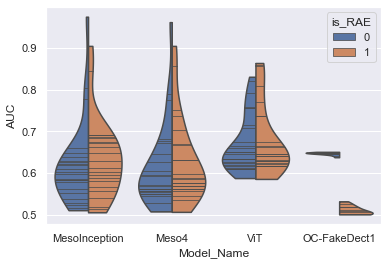

In [827]:
ax = sns.violinplot(x='Model_Name', y='AUC', hue="is_RAE", data=df, inner="stick", cut=0, split=True, scale="width")


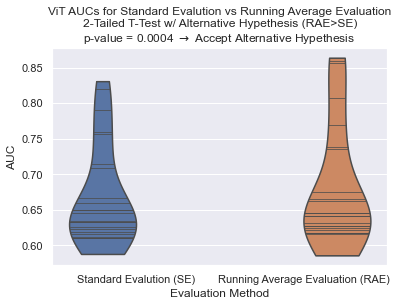

In [816]:
vit_df = best_df[best_df["Model_Name"].isin(["ViT"])].sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)
# vit_df

# rae vs non-rae
vit_rae = vit_df[vit_df["Testset"].str.contains("rae")]
vit_nonrae = vit_df[~vit_df["Testset"].str.contains("rae")]
vit_nonrae = vit_nonrae[~vit_nonrae["Testset"].str.contains("DFDB")] # no eq lens

# ttest_rel assumes relationship, and not eqal var
vit_raeVnonrae_pvalue = ttest_rel(vit_rae['AUC'], vit_nonrae['AUC'], alternative="greater")[1] 
# p<0.05 means not alternative (vit_rae['AUC'] > vit_nonrae['AUC'])

data1 = vit_rae[["AUC"]].assign(RAE=1)
data2 = vit_nonrae[["AUC"]].assign(RAE=0)

cdf = pd.concat([data1, data2])
mdf = pd.melt(cdf, id_vars=['RAE'], var_name=['AUC'])

# LOOK AT https://seaborn.pydata.org/generated/seaborn.violinplot.html
ax = sns.violinplot(x='RAE', y='value', hue="RAE", data=mdf, inner="stick", cut=0)#, split=True)
ax.set_title(f"ViT AUCs for Standard Evalution vs Running Average Evaluation\n2-Tailed T-Test w/ Alternative Hypethesis (RAE>SE)\np-value = {vit_raeVnonrae_pvalue:.4f} $\\rightarrow$ Accept Alternative Hypethesis ")
ax.set_xticklabels(["Standard Evalution (SE)", "Running Average Evaluation (RAE)"])
ax.set_xlabel("Evaluation Method")
ax.set_ylabel("AUC")
ax.get_legend().remove()
plt.show()



In [817]:

df["is_RAE"] = 0
df.loc[df["Testset"].str.contains("rae"), "is_RAE"] = 1
df["is_AVG_Trainset"] = 0
df.loc[df["Trainset"].str.contains("avg"), "is_AVG_Trainset"] = 1
df["is_AVG_Testset"] = 0
df.loc[df["Testset"].str.contains("avg"), "is_AVG_Testset"] = 1
df['Testset'] = df['Testset'].replace(['CDFv2avg', "CDFv2rnd"], 'CDFv2')
df['Testset'] = df['Testset'].map(lambda x: x.replace("rae", ""))
df['Testset'] = df['Testset'].map(lambda x: x.replace("avg", ""))
df['Testset'] = df['Testset'].map(lambda x: x.replace("rnd", ""))
df['Testset'] = df['Testset'].replace(['AVG'], 'CDFv2')
df['Testset'] = df['Testset'].replace(['RND'], 'CDFv2')
df['Trainset'] = df['Trainset'].map(lambda x: x.replace("avg", ""))
df['Trainset'] = df['Trainset'].map(lambda x: x.replace("rnd", ""))

set(df["Testset"]), set(df["Trainset"])

({'CDFv2', 'DF', 'DFDB', 'F2F', 'FS', 'FSHFT', 'NT'},
 {'CDFv2', 'DF', 'DFDB', 'F2F'})

<AxesSubplot:xlabel='Testset', ylabel='AUC'>

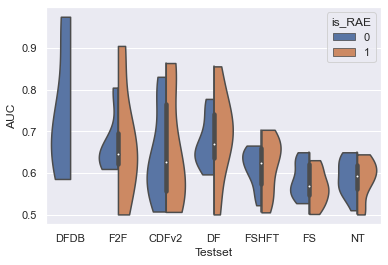

In [818]:
# rae vs non-rae by test_dataset
sns.violinplot(x="Testset", y='AUC', hue="is_RAE", data=df, split=True, cut=0, scale="width")#, palette="Set1")

<AxesSubplot:xlabel='Testset', ylabel='AUC'>

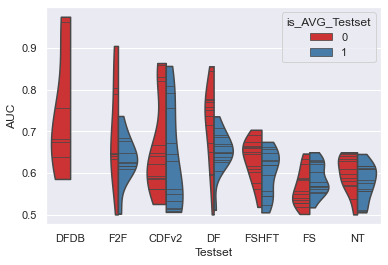

In [819]:
# avg vs rnd
sns.violinplot(x="Testset", y='AUC', hue="is_AVG_Testset", data=df, inner="stick", split=True, cut=0, palette="Set1")

In [820]:
# best models
best_df = df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)
best_df.loc[best_df[["Testset"]].drop_duplicates().index] # top models by testset sorted by AUC

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
101,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900,0,0,0
135,MesoInception,F2F,F2F,0.905,0.318,0.252,0.430,1,0,0
49,ViT,CDFv2,CDFv2,0.864,0.963,0.930,0.999,1,0,0
64,Meso4,DF,DF,0.856,0.175,0.159,0.194,1,0,0
67,Meso4,DF,FSHFT,0.704,0.380,0.316,0.476,1,0,0
9,ViT,CDFv2,NT,0.650,0.594,0.597,0.592,0,1,0
146,OC-FakeDect1,DFDB,FS,0.650,0.381,0.299,0.527,0,0,1


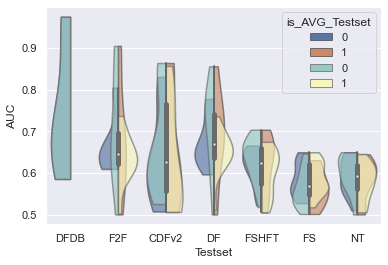

In [821]:
# sns.violinplot(x="Model_Name", y='AUC', hue="is_RAE", data=df, inner="stick", split=True, width=1)
# sns.violinplot(x="Model_Name", y='AUC', hue="is_AVG_Testset", data=df, inner="stick", split=True)

ax1 = sns.violinplot(x="Testset", y='AUC', hue="is_RAE", data=df, split=True, cut=0)
ax2 = sns.violinplot(x="Testset", y='AUC', hue="is_AVG_Testset", data=df, split=True, cut=0, palette="Set3")#, dodge=True)
plt.setp(ax2.collections, alpha=.65)
plt.show()

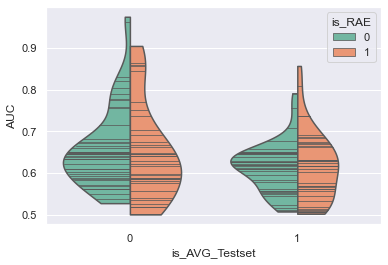

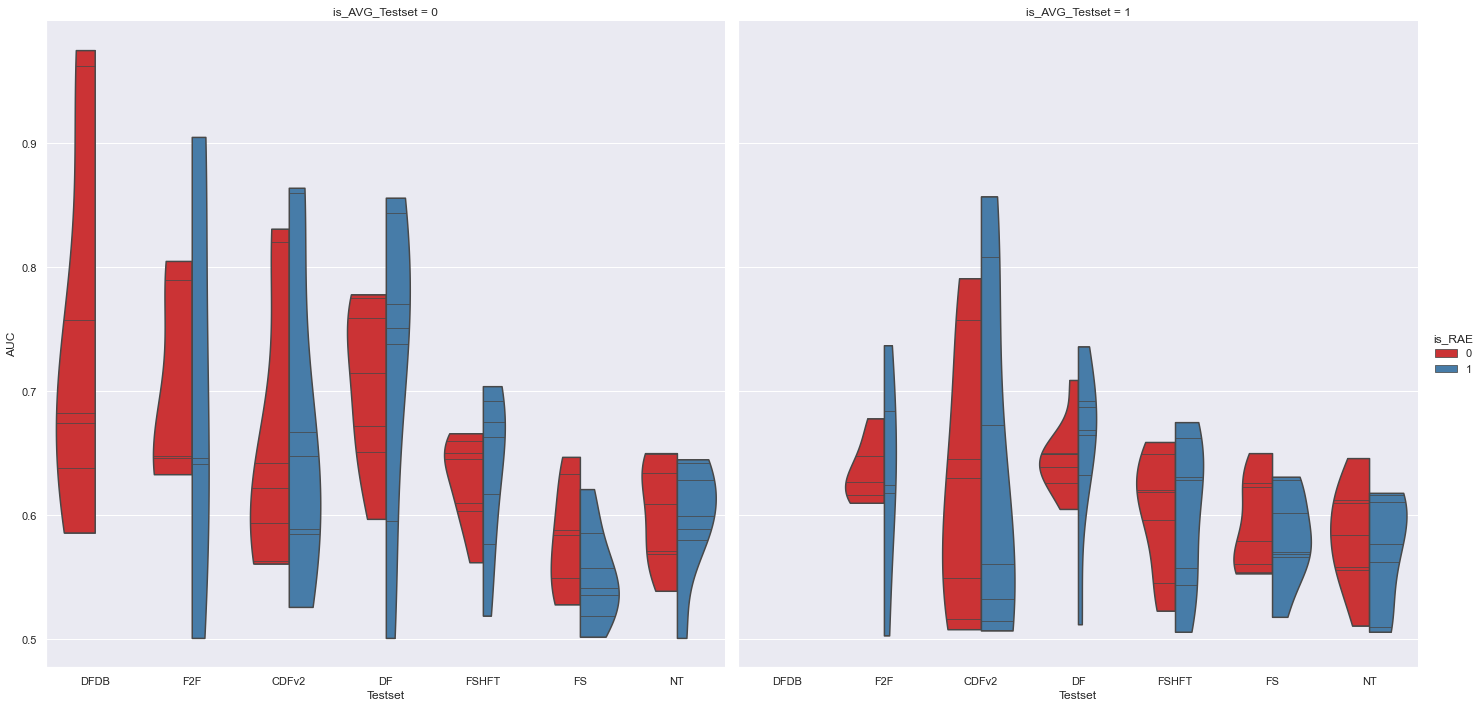

In [822]:
# testset is avg vs rae eval
sns.violinplot(x="is_AVG_Testset", y='AUC', hue="is_RAE", data=df, inner="stick", split=True, cut=0,  palette="Set2")

sns.catplot(x="Testset", y="AUC",
                hue="is_RAE", col="is_AVG_Testset",
                data=df, kind="violin", split=True,
                height=10, aspect=1, palette="Set1", cut=0, inner="stick");

In [823]:
print(df.to_latex())

\begin{tabular}{llllrrrrrrr}
\toprule
{} &     Model\_Name & Trainset & Testset &    AUC &     F1 &  Precision &  Recall &  is\_RAE &  is\_AVG\_Trainset &  is\_AVG\_Testset \\
\midrule
101 &  MesoInception &       DF &    DFDB &  0.975 &  0.925 &      0.953 &   0.900 &       0 &                0 &               0 \\
55  &          Meso4 &       DF &    DFDB &  0.962 &  0.904 &      0.930 &   0.880 &       0 &                0 &               0 \\
89  &          Meso4 &      F2F &     F2F &  0.905 &  0.128 &      0.118 &   0.139 &       1 &                0 &               0 \\
135 &  MesoInception &      F2F &     F2F &  0.905 &  0.318 &      0.252 &   0.430 &       1 &                0 &               0 \\
49  &            ViT &    CDFv2 &   CDFv2 &  0.864 &  0.963 &      0.930 &   0.999 &       1 &                0 &               0 \\
24  &            ViT &    CDFv2 &   CDFv2 &  0.860 &  0.953 &      0.944 &   0.964 &       1 &                1 &               0 \\
13  &            

C:\Users\rapto\AppData\Local\Temp\ipykernel_10008\2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
